# Procesamiento Adaptativo de Señales Aleatorias
# Trabajo Práctico N°2 - Filtro óptimo
# Notebook #1 - Análisis de señales
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

In [26]:
# # Mount Google Drive resources
# from google.colab import drive
# drive.mount('/content/drive/')
# base = '/content/drive/Shared drives/BikeTeam/Procesamiento Adaptativo de Señales/tp2/pasa-tp2'

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
from IPython.display import Audio
from scipy.io import wavfile
from scipy import linalg, hamming
from scipy.fft import fft, fftfreq

In [28]:
# Define samplerate for input signals
samplerate = 44100 # Hz

# Define track length
tracklen = 10 # sec

In [39]:
def plot_spectrograms(original, response, title, window='hanning', ylim=None):

    # Open both WAV files
    fs_o, y_o = wavfile.read(original)
    fs_r, y_r = wavfile.read(response)

    # Check both sample rates
    if fs_o != fs_r:
        raise Exception('Both sample rates must be equal!')

    fig, axs = plt.subplots(2, 1, figsize=(25,10), sharex=True)
    fig.suptitle(title, fontsize=20)

    # Original signal spectrogram plot
    f_o, t_o, sxx_o = sps.spectrogram(y_o, fs_o, window=window, nperseg=512, noverlap=1)
    axs[0].set_ylabel('Frequency [Hz]')
    axs[0].set_title('Original')

    # Response spectrogram plot
    f_r, t_r, sxx_r = sps.spectrogram(y_r, fs_r, window=window, nperseg=512, noverlap=1)
    axs[1].set_ylabel('Frequency [Hz]')
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_title('Response')
    
    axs[0].specgram(y_o, Fs=fs_o)
    axs[1].specgram(y_r, Fs=fs_r)
    
    # y axis limit
    if (ylim != None):
            if (len(ylim) == 2):
                axs[1].set_ylim(ylim[0],ylim[1])
                axs[0].set_ylim(ylim[0],ylim[1])


    #axs[0].pcolormesh(t_o, f_o, sxx_o, shading='gouraud')
    #axs[1].pcolormesh(t_r, f_r, sxx_r, shading='gouraud')
  

In [40]:
def to_wav(track, samplerate, filename, scale = 1):
    scaled_track = np.int16(track*32767*scale)
    wavfile.write(filename, samplerate, scaled_track)
    return scaled_track

In [41]:
def print_signal(x, y, title, samplerate=None, color='blue', xlim=None, window='hann', ylim=None):
    fig, axs = plt.subplots(2, 1, figsize=(25,10))
    fig.suptitle(title, fontsize=20)
    
    # Time plot
    axs[0].grid()
    axs[0].set_xlabel('Time [sec]')
    if (xlim != None):
        if (len(xlim) == 2):
            axs[0].set_xlim(xlim[0],xlim[1])
    axs[0].plot(x, y, color=color)
            
    # Spectrogram plot
    if samplerate != None:
        f, t, Sxx = sps.spectrogram(y, samplerate, window=window, nperseg=256, noverlap=64)
        axs[1].set_ylabel('Frequency [Hz]')
        axs[1].set_xlabel('Time [sec]')
        if (ylim != None):
            if (len(ylim) == 2):
                axs[1].set_ylim(ylim[0],ylim[1])
        axs[1].pcolormesh(t, f, Sxx, shading='gouraud')

# 1. Señales de excitación

In [42]:
base = '..'
record_base = base + '/assets/recorded_sounds/wavs/'
original_base = base + '/assets/test_signals/'
audios_dict = {
    # AudioType: (recorded, original)
    'song': 'darkside.wav',
    'voice': 'whereiam.wav',
    'linear sweep': 'linear.wav',
    'periodic linear sweep': 'multiple_lin.wav',
    'exp sweep': 'exponential.wav',
    'periodic exp sweep': 'multiple_exp.wav',
    'square': 'rectangular.wav',
    'wgn': 'white-noise.wav'
}

## 1.1 Señal de voz

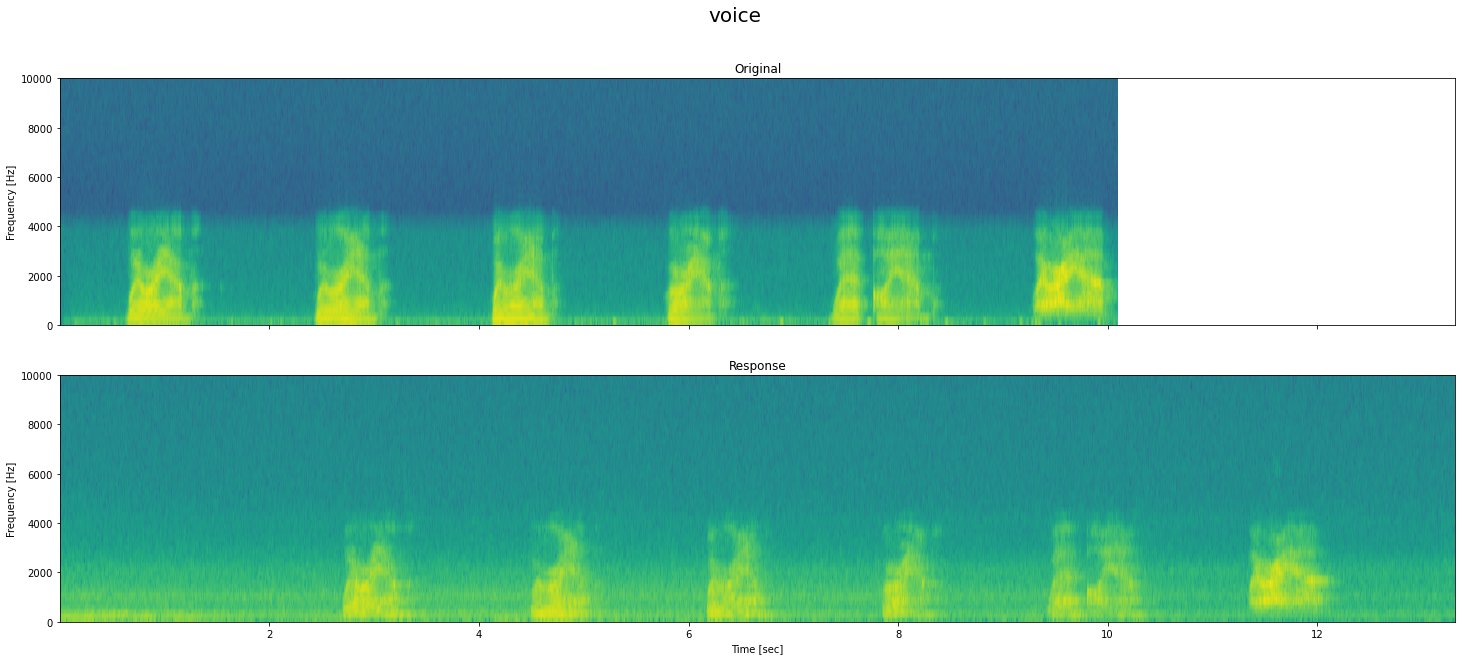

In [44]:
# Plot spectrograms
tag = 'voice'
plot_spectrograms(original_base + audios_dict[tag], record_base + audios_dict[tag], tag, ylim=(0,10000))

## 1.2 Fragmento de canción

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_19492/3636548642.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_o, y_o = wavfile.read(original)


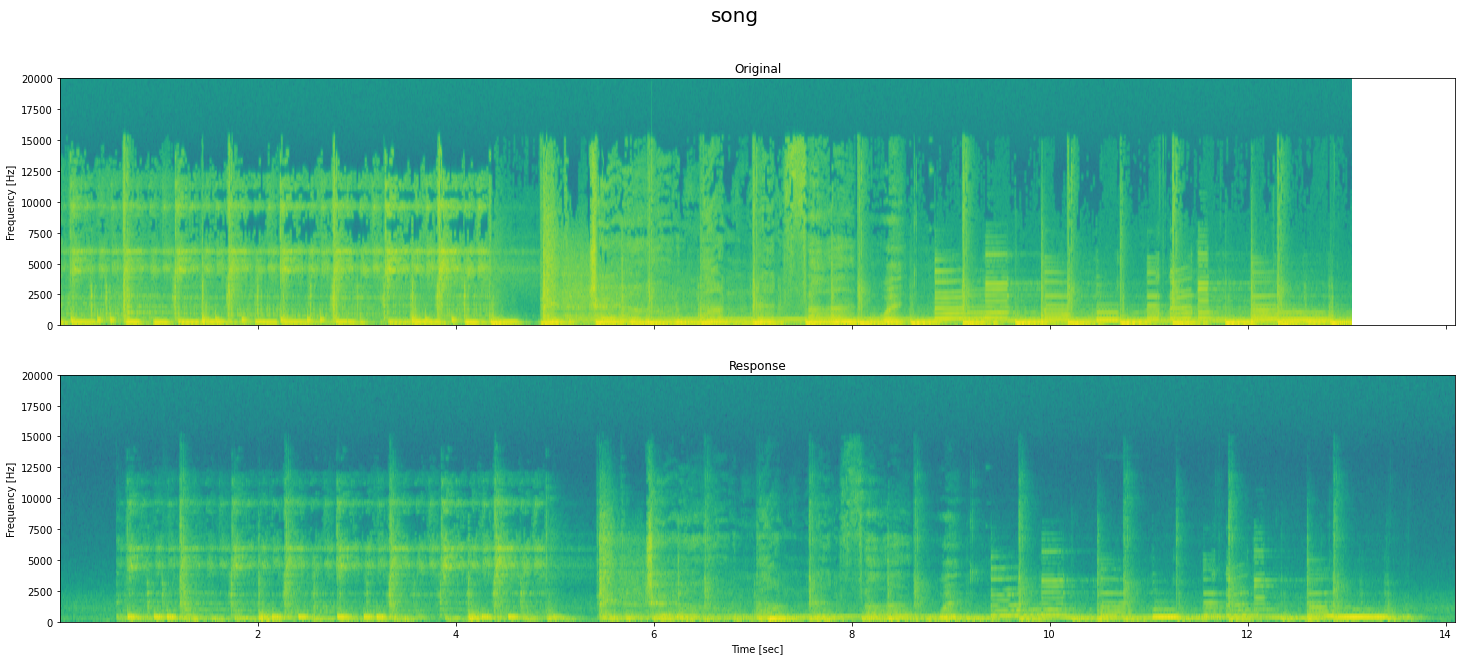

In [47]:
# Plot spectrograms
tag = 'song'
plot_spectrograms(original_base + audios_dict[tag], record_base + audios_dict[tag], tag, ylim=(0,20000))

## 1.3 Señal rectangular

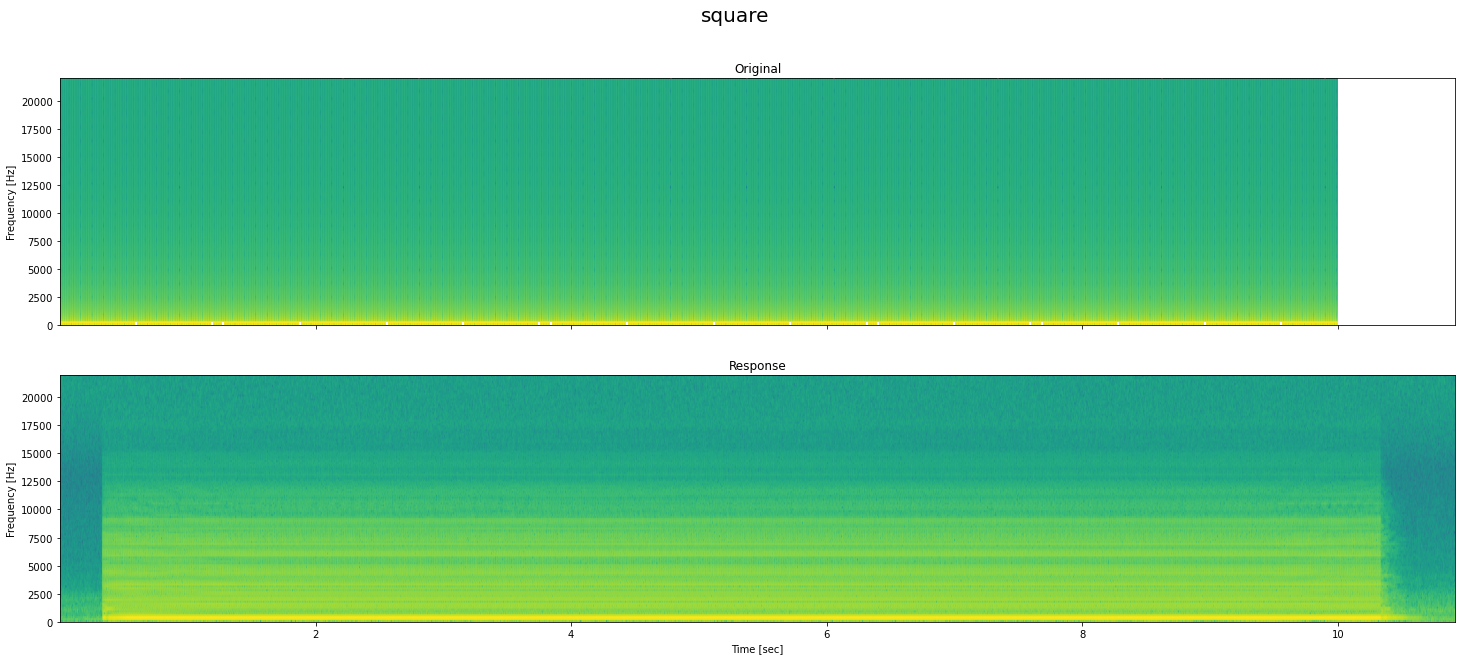

In [59]:
tag = 'square'

rec_freq = 100 # Hz

# Generate square signal
rec_t = np.arange(0, tracklen, 1/samplerate)
rec = sps.square(rec_t*2*np.pi*rec_freq) 

# Generate WAV file
rec_scaled = to_wav(rec, samplerate, original_base + audios_dict[tag][1], scale=0.9)

# Plot spectrograms
plot_spectrograms(original_base + audios_dict[tag], record_base + audios_dict[tag], tag, ylim=(0,22000))

## 1.4 Barrido lineal en frecuencia

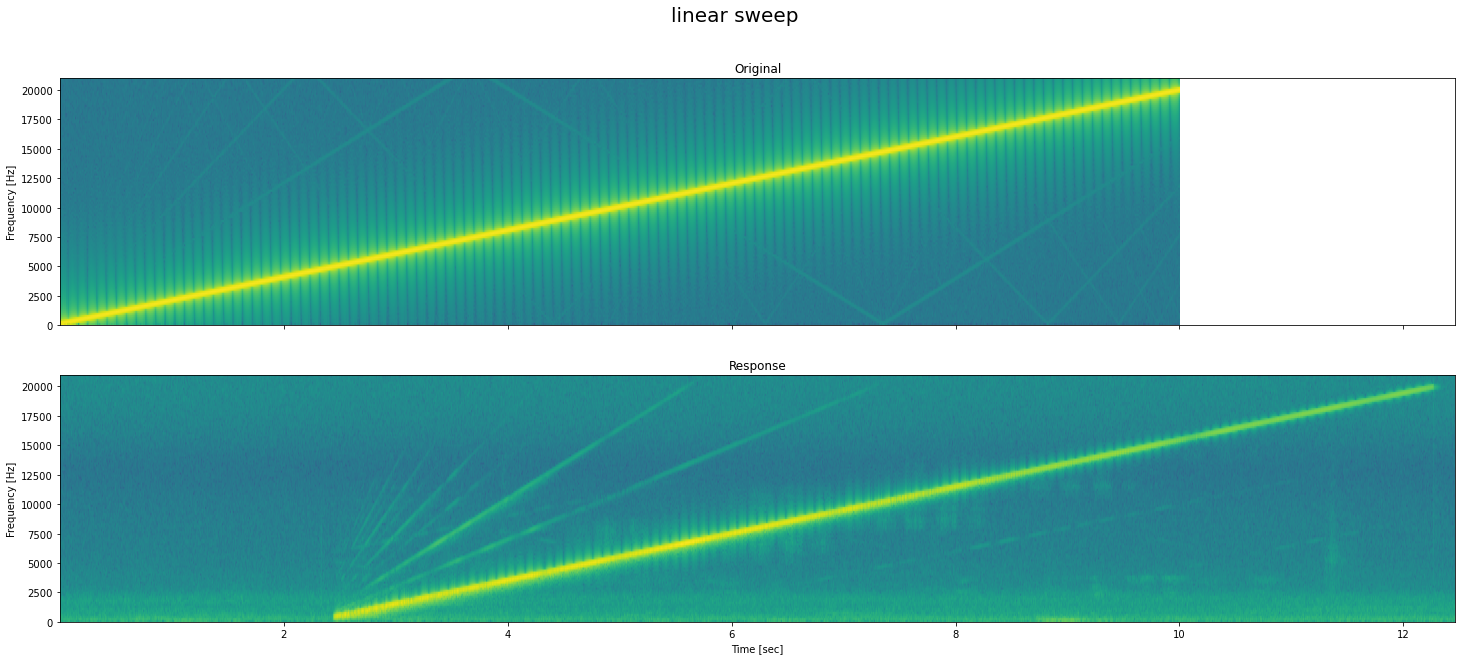

In [52]:
tag = 'linear sweep'

ls_f0 = 20 # Hz
ls_f1 = 20000 # Hz

ls_t = np.arange(0, tracklen, 1/samplerate)

# Generate frequency sweep
linear_sweep = sps.chirp(ls_t, ls_f0, ls_t[-1], ls_f1, method='linear')

# Generate WAV file
linear_sweep_scaled = to_wav(linear_sweep, samplerate, original_base + audios_dict[tag][1], scale=0.9)

# Plot spectrograms
plot_spectrograms(original_base + audios_dict[tag], record_base + audios_dict[tag], tag, ylim=(0,21000))

## 1.5 Barrido lineal en frecuencia (periódico)

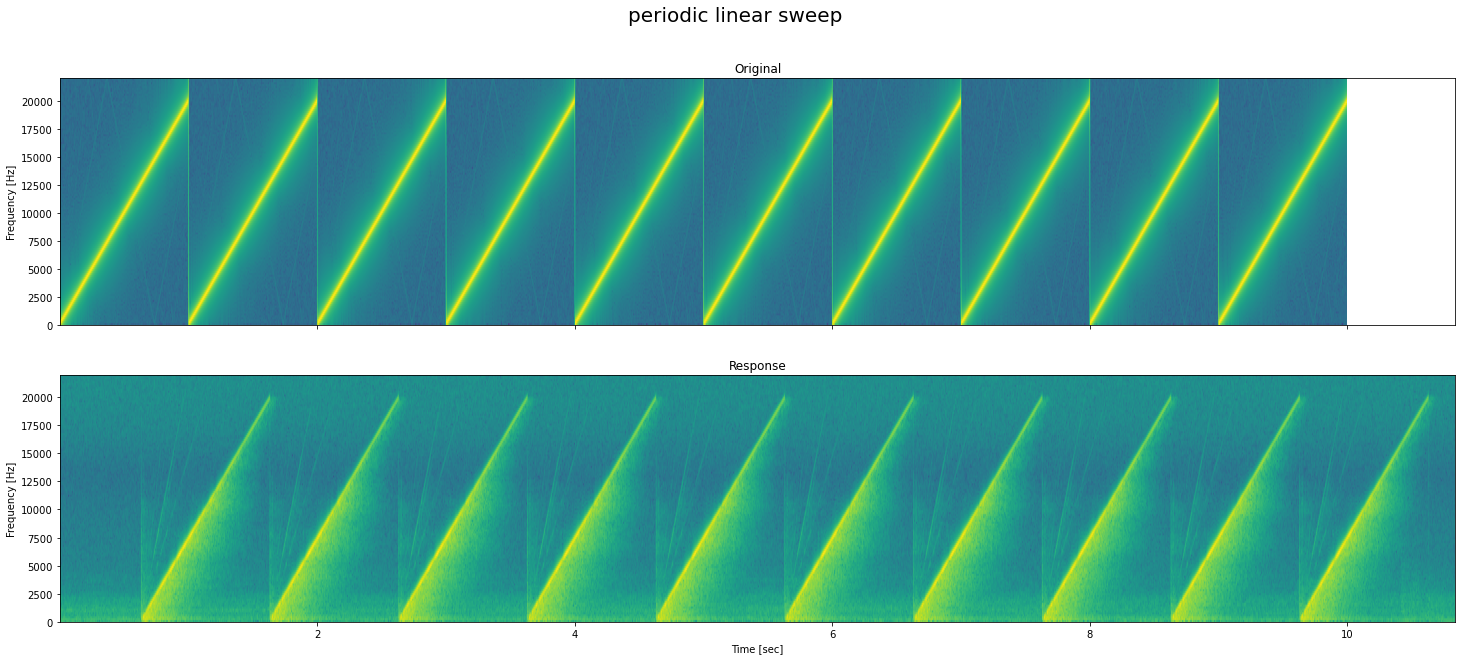

In [53]:
tag = 'periodic linear sweep'

lsp_f0 = 20 # Hz
lsp_f1 = 20000 # Hz

lsp_t = np.arange(0, 1, 1.0/samplerate)

it = 10 # sec

lsp_t_total = np.arange(0, it, 1.0/samplerate)

linear_sweep_periodic = np.array([])

for i in range(it):
    # Generate frequency sweep
    lsp_period = sps.chirp(lsp_t, lsp_f0, lsp_t[-1], lsp_f1, method='linear')
    linear_sweep_periodic = np.concatenate((linear_sweep_periodic, lsp_period), axis=None)
    
# Generate WAV file
linear_sweep_scaled = to_wav(linear_sweep_periodic, samplerate,original_base + audios_dict[tag][1], scale=0.9)

# Plot spectrograms
plot_spectrograms(original_base + audios_dict[tag], record_base + audios_dict[tag], tag, ylim=(0,22000))

## 1.6 Barrido exponencial en frecuencia

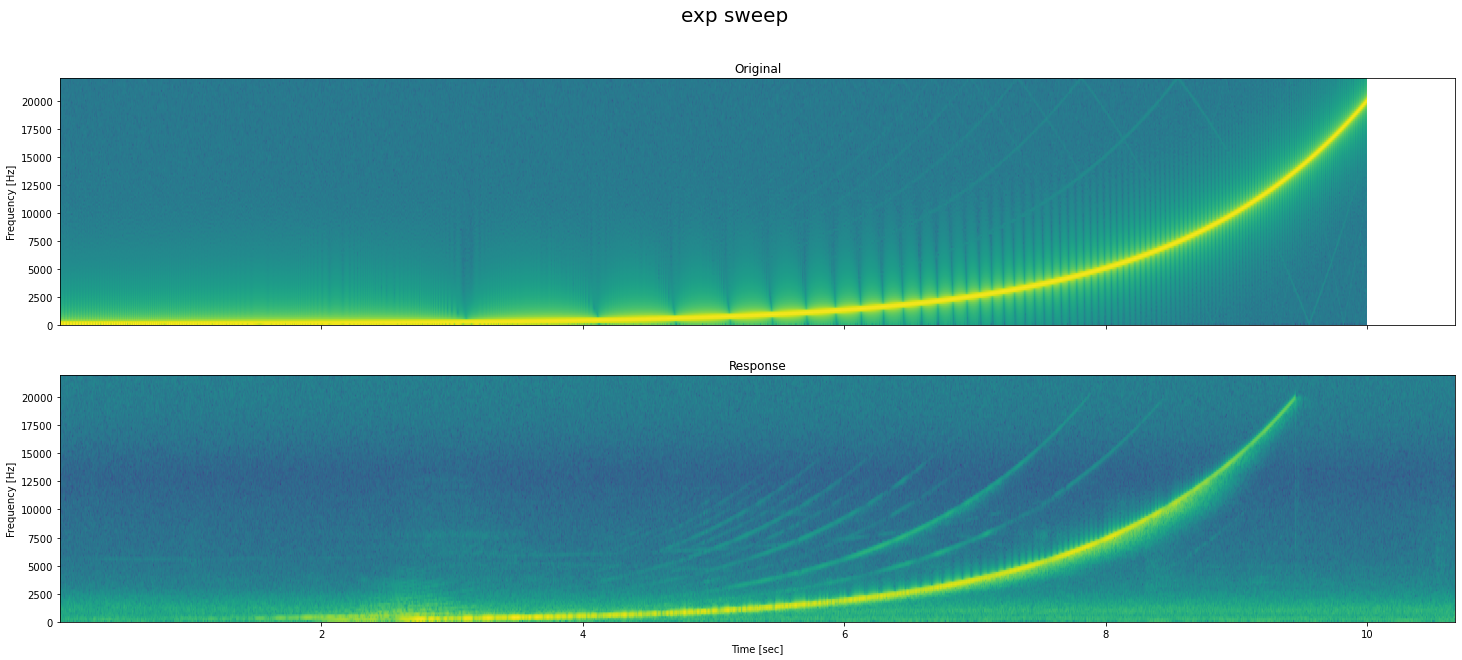

In [54]:
tag = 'exp sweep'

# First declare the variables
es_f0 = 20
es_f1 = 20e3
es_T = 10

es_N = es_T*samplerate

# create the array with times
es_time = np.linspace(0, es_N/samplerate, es_N)
es_k = (es_f1/es_f0)**(1/es_T)

# array with variable k^t
es_k_t = np.array([es_k**i for i in es_time])

# array with output signal
es = np.sin(2*np.pi*es_f0*(es_k_t - 1)/np.log(es_k))

# Generate WAV file
es_scaled = to_wav(es, samplerate,original_base + audios_dict[tag][1], scale=0.9)

# Plot spectrograms
plot_spectrograms(original_base + audios_dict[tag], record_base + audios_dict[tag], tag, ylim=(0,22000))

## 1.7 Barrido exponencial en frecuencia (periódico)

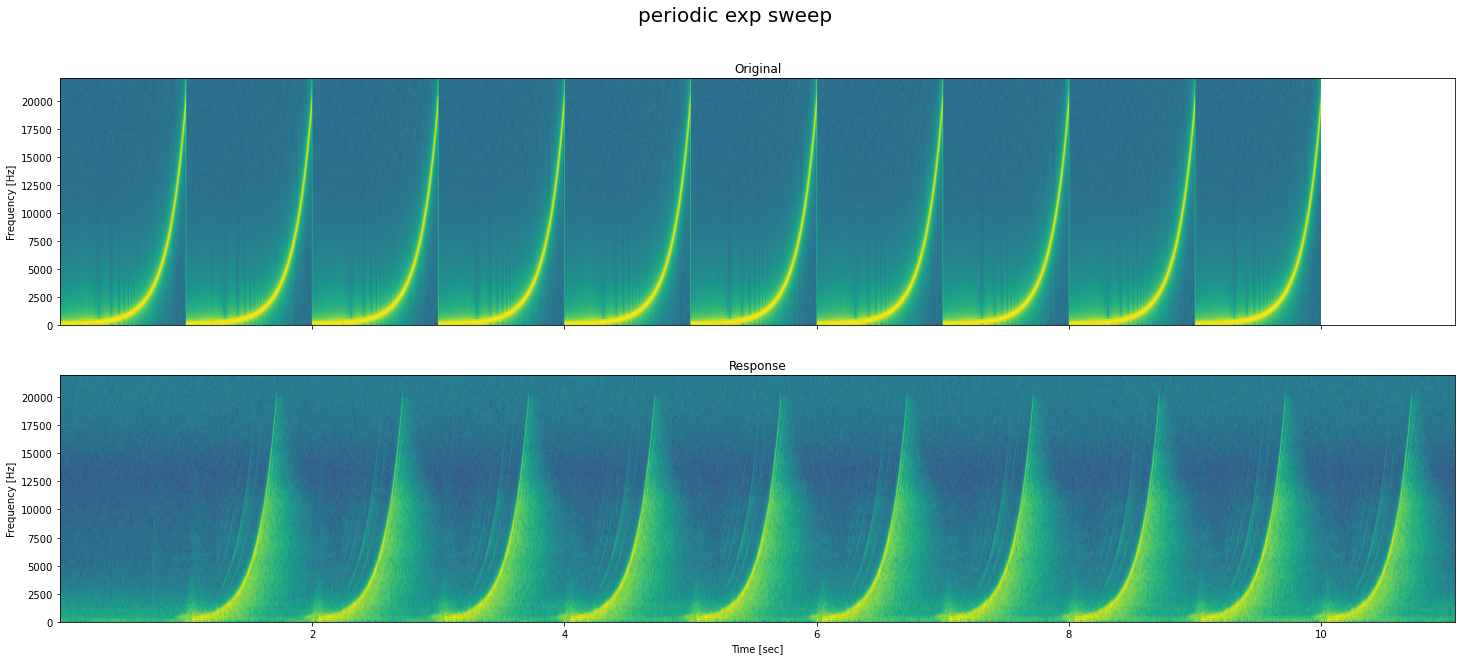

In [55]:
tag = 'periodic exp sweep'

esp_f0 = 20 # Hz
esp_f1 = 20000 # Hz

esp_T = 1
esp_t = np.arange(0, esp_T, 1.0/samplerate)

it = 10 # sec

esp_t_total = np.arange(0, it, 1.0/samplerate)


total_exp_sweep = np.array([])


for i in range(it):
    esp_N = esp_T*samplerate
    # create the array with times
    esp_time = np.linspace(0, esp_N/samplerate, esp_N)
    esp_k = (esp_f1/esp_f0)**(1/esp_T)

    # array with variable k^t
    esp_k_t = np.array([esp_k**i for i in esp_time])

    # array with output signal
    exp_sweep = np.sin(2*np.pi*esp_f0*(esp_k_t - 1)/np.log(esp_k))
    
    total_exp_sweep = np.concatenate((total_exp_sweep, exp_sweep), axis=None)

# Generate WAV file
total_exp_sweep_scaled = to_wav(total_exp_sweep, samplerate,original_base + audios_dict[tag][1], scale=0.9)

# Plot spectrograms
plot_spectrograms(original_base + audios_dict[tag], record_base + audios_dict[tag], tag, ylim=(0,22000))

## 1.8 Ruido blanco gaussiano

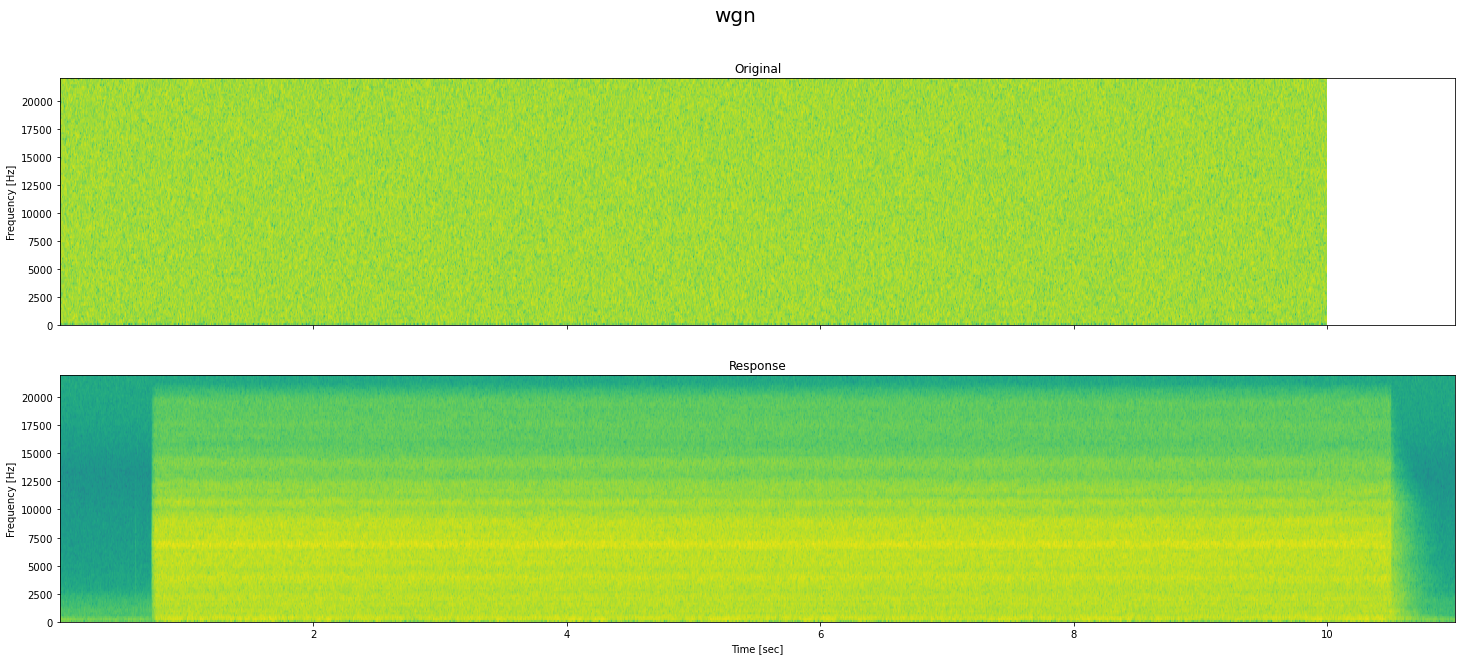

In [56]:
tag = 'wgn'

wgn_sigma = 1

wgn_t = np.arange(0, 10, 1/samplerate)

# Generate white gaussian noise signal
wgn = np.random.normal(0, wgn_sigma, wgn_t.shape[0]) # Media 0, varianza 1. Ruido Gaussiano.

# Generate WAV file
wgn_scaled = to_wav(wgn, samplerate,original_base + audios_dict[tag][1], scale=0.9)

# Plot spectrograms
plot_spectrograms(original_base + audios_dict[tag], record_base + audios_dict[tag], tag, ylim=(0,22000))